# Reducing Readmission Risk using Predictive Analytics

## Problem

### What is a Readmission?
Admission to a hospital within 30 days of a discharge from the same or another hospital.

### Why is it important?
* Improve patient's health
* Reduce healthcare costs - organizations shelling out billions each year on avoidable episodes

### Hospital Readmissions Reduction Program (HRRP)
* CMS HRRP was introduced in 2012 with readmission reduction into the mind
* CMS has doled out 2.5 billion US dollars in penalties, with an estimated 564 million US dollars in fiscal year 2018 alone, up from the 528 million US dollars in 2017. 

### How to reduce Readmissions?
* Greater than 50% of readmitted patients have no post-discharge contact with healthcare professionals
* Use EHR to identify risk patients and recommend interventions that use minimal resources
* Healthcare providers can work with patients to monitor chronic conditions from their homes use mobile apps:
    
    * patient data, such as body weight or blood glucose levels
    
    * help patients with their post-discharge treatment plans

# Dataset

## Diabetes 130-US hospitals for years 1999-2008 Data Set

URL: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

* The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals 
* Over 50 features representing patient and hospital outcomes

![](figures/Data_Information.png)


# Predictive Modeling

* Load Data
* Define the Independent Variables and Dependent Variable
* XGBoost with cross-validation to build a classifier
* Evaluate and tune the model on a validation dataset
* Test the final model of the test set
* Important Features
* Statistical Significance

## Data

In [71]:
from imblearn import *
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier

### Load the Train, Test and Validation Datasets

In [72]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
validation_df = pd.read_csv("validation.csv")

### Drop 'encounter_id', 'patient_nbr'

In [73]:
train_df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)
test_df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)
validation_df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [74]:
train_df

,readmitted,zstd_number_diagnoses_c,zstd_num_lab_procedures_c,zstd_num_medications_c,zstd_log_number_inpatient,zstd_log_number_outpatient,zstd_log_number_emergency,zstd_time_in_hospital,zstd_num_procedures,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,...,grouped_diag_3_58,grouped_diag_3_59,grouped_diag_3_60,grouped_diag_3_61,grouped_diag_3_62,grouped_diag_3_64,grouped_diag_3_65,grouped_diag_3_66,grouped_diag_3_67,grouped_diag_3_68,grouped_diag_3_69,grouped_diag_3_70,grouped_diag_3_71,grouped_diag_3_72,grouped_diag_3_73,grouped_diag_3_74,grouped_diag_3_75,grouped_diag_3_78,grouped_diag_3_79,grouped_diag_3_80,grouped_diag_3_81,grouped_diag_3_82,grouped_diag_3_83,grouped_diag_3_84,grouped_diag_3_85,grouped_diag_3_86,grouped_diag_3_87,grouped_diag_3_88,grouped_diag_3_89,grouped_diag_3_90,grouped_diag_3_91,grouped_diag_3_92,grouped_diag_3_93,grouped_diag_3_94,grouped_diag_3_95,grouped_diag_3_96,grouped_diag_3_97,grouped_diag_3_98,grouped_diag_3_99,grouped_diag_3_E8,grouped_diag_3_E9,grouped_diag_3_UN,grouped_diag_3_V0,grouped_diag_3_V1,grouped_diag_3_V2,grouped_diag_3_V4,grouped_diag_3_V5,grouped_diag_3_V6,grouped_diag_3_V7,grouped_diag_3_V8
0,1,0.887947,-0.146466,0.831954,3.362715,1.471852,-0.264086,-1.116991,2.608617,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,-0.115183,-1.604287,0.445819,-0.341688,-0.352702,-0.264086,-1.116991,2.608617,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.887947,-0.799972,-0.455161,-0.341688,-0.352702,-0.264086,-0.776822,2.608617,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.887947,0.004343,0.960665,-0.341688,1.471852,-0.264086,-0.436654,-0.810361,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0.887947,0.004343,-0.841295,-0.341688,-0.352702,-0.264086,0.243682,-0.240532,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,0,-1.619879,-1.905905,-0.970007,-0.341688,-0.352702,-0.264086,-1.116991,-0.240532,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56343,0,-1.619879,0.356231,-0.069027,-0.341688,-0.352702,-0.264086,0.924019,2.038787,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Define X and y

In [75]:
# Train data X, y
X_train = train_df.drop("readmitted", axis=1)
y_train = train_df['readmitted']

# Test data X, y
X_test = test_df.drop("readmitted", axis=1)
y_test = test_df['readmitted']

# Validation data X, y
X_val = validation_df.drop("readmitted", axis=1)
y_val = validation_df['readmitted']

## Imbalanced Dataset

![](figures/Data_Balancing4.png)

In [76]:
# Instantiate SMOTE and fit
os = SMOTE(random_state=0)
columns = X_train.columns

data_X_smote, data_y_smote = os.fit_sample(X_train, y_train)
data_X_smote = pd.DataFrame(data=data_X_smote, columns=columns)
data_y_smote = pd.DataFrame(data=data_y_smote, columns=['readmitted'])

In [77]:
# Check the numbers of our data
print(f"Length of oversampled data: {len(data_X_smote)}")
print(f"No readmissions in oversampled data: {len(data_y_smote[data_y_smote['readmitted'] == 0])}")
print(f"Readmissions in oversampled data: {len(data_y_smote[data_y_smote['readmitted'] == 1])}")
print(f"Proportion of no readmissions in oversampled data: {len(data_y_smote[data_y_smote['readmitted'] == 0])/len(data_y_smote)}")
print(f"Proportion of readmissions in oversampled data: {len(data_y_smote[data_y_smote['readmitted'] == 1])/len(data_y_smote)}")

Length of oversampled data: 102656
No readmissions in oversampled data: 51328
Readmissions in oversampled data: 51328
Proportion of no readmissions in oversampled data: 0.5
Proportion of readmissions in oversampled data: 0.5


# Predictive Modeling

In [92]:
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier

In [79]:
def rename_column_names(colname):
    colname = "_".join(colname.split('-'))
    colname = "_".join(colname.split(','))
    colname = "_".join(colname.split('<'))
    colname = "_".join(colname.split('/'))
    colname = "_".join(colname.split('.'))
    colname = "_".join(colname.split('['))
    colname = "_".join(colname.split(']'))
    colname = "".join(colname.split(')'))
    colname = "_".join(colname.split('('))
    return colname

In [80]:
new_train_colnames = list(map(lambda x: rename_column_names(x), data_X_smote.columns.tolist()))
new_validation_colnames = list(map(lambda x: rename_column_names(x), X_val.columns.tolist()))
new_test_colnames = list(map(lambda x: rename_column_names(x), X_test.columns.tolist()))

In [81]:
data_X_smote.columns = new_train_colnames
X_val.columns = new_validation_colnames
X_test.columns = new_test_colnames

## Base Model

In [84]:
dtrain = xgb.DMatrix(data_X_smote, label=data_y_smote)
dvalidation = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [15]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [16]:
# specify validations set to watch performance
watchlist = [(dvalidation, 'eval'), (dtrain, 'train')]

In [17]:
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-auc:0.50528	train-auc:0.59298
[1]	eval-auc:0.52233	train-auc:0.70152
[2]	eval-auc:0.53991	train-auc:0.77800
[3]	eval-auc:0.52092	train-auc:0.81241
[4]	eval-auc:0.54647	train-auc:0.85271
[5]	eval-auc:0.52289	train-auc:0.86821
[6]	eval-auc:0.53491	train-auc:0.88630
[7]	eval-auc:0.53485	train-auc:0.89711
[8]	eval-auc:0.53355	train-auc:0.90847
[9]	eval-auc:0.53708	train-auc:0.91924
[10]	eval-auc:0.53879	train-auc:0.92572
[11]	eval-auc:0.53310	train-auc:0.92787
[12]	eval-auc:0.54582	train-auc:0.92963
[13]	eval-auc:0.55001	train-auc:0.93337
[14]	eval-auc:0.55661	train-auc:0.93527
[15]	eval-auc:0.55464	train-auc:0.93777
[16]	eval-auc:0.55327	train-auc:0.94013
[17]	eval-auc:0.55346	train-auc:0.94410
[18]	eval-auc:0.54937	train-auc:0.94627
[19]	eval-auc:0.55522	train-auc:0.94736
[20]	eval-auc:0.55739	train-auc:0.94831
[21]	eval-auc:0.55942	train-auc:0.94951
[22]	eval-auc:0.55379	train-auc:0.95118
[23]	eval-auc:0.55312	train-auc:0.95211
[24]	eval-auc:0.55114	train-auc:0.95273


## Base model performance
### Base model predictions

In [18]:
preds = bst.predict(dvalidation)
print(preds)
labels = dvalidation.get_label()
print(labels)

[0.19280449 0.12743588 0.30505604 ... 0.28943792 0.1323631  0.15833104]
[1. 0. 0. ... 0. 0. 0.]


In [19]:
print('error={:.2f}' .format(sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) /
       float(len(preds))))

error=0.09


In [20]:
bst.save_model('../0001.model')
# dump model
bst.dump_model('../0001_dump.raw.txt')
# dump model with feature map
bst.dump_model('../0001_dump.nice.txt')

## Hyperparameter Tuning

### Parameters Outside the params dictionary -  Number Boost Round and Early Stopping Rounds

**num_boost_round** - 
* Number or trees to build
* Dependent on other parameters and hence has to be retrained with every update
* In XGBoost the model is evaluated at each step and the number of trees can be limited using another parameter


**early_stopping_rounds** 
*  Stops the training and adding more trees after N rounds.

In [21]:
# Define a default parameters to begin with as a "param" dictionary
param = {'max_depth': 6, 
         'min_child_weight': 1,
         'eta': 0.3, 
         'subsample': 1,
         'colsample_bytree': 1,
         'objective': 'binary:logistic'}

In [22]:
# Add the evaluation metric to the param dictionary
param['eval_metric'] = "auc"

# set "num_boost_rounds" to a large number
num_boost_round = 999

In [23]:
model_001 = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=[(dvalidation, "Validation")], early_stopping_rounds=10)

[0]	Validation-auc:0.52540
[1]	Validation-auc:0.54070
[2]	Validation-auc:0.54131
[3]	Validation-auc:0.54563
[4]	Validation-auc:0.54451
[5]	Validation-auc:0.54852
[6]	Validation-auc:0.54726
[7]	Validation-auc:0.55802
[8]	Validation-auc:0.55923
[9]	Validation-auc:0.55410
[10]	Validation-auc:0.55327
[11]	Validation-auc:0.55144
[12]	Validation-auc:0.55453
[13]	Validation-auc:0.55931
[14]	Validation-auc:0.56167
[15]	Validation-auc:0.55641
[16]	Validation-auc:0.55300
[17]	Validation-auc:0.55390
[18]	Validation-auc:0.55351
[19]	Validation-auc:0.55451
[20]	Validation-auc:0.55339
[21]	Validation-auc:0.55164
[22]	Validation-auc:0.55358
[23]	Validation-auc:0.55495


In [24]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model_001.best_score,
                 model_001.best_iteration+1))

Best AUC: 0.56 with 15 rounds


### Using XGBoost’s CV  with default parameters

In [25]:
cv_results = xgb.cv(param,
                    dtrain,
                    num_boost_round=num_boost_round,
                    seed=42,
                    nfold=5,
                    metrics={"auc"},
                    early_stopping_rounds=10)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.779162,0.001135,0.777394,0.003584
1,0.876431,0.009321,0.874326,0.010016
2,0.893027,0.013246,0.890675,0.015073
3,0.923603,0.006599,0.921431,0.008417
4,0.941362,0.002159,0.939558,0.003602
5,0.948017,0.001668,0.946220,0.002884
6,0.952651,0.000426,0.950967,0.001851
7,0.955319,0.000700,0.953377,0.001931
8,0.957698,0.000708,0.955801,0.001861
9,0.958794,0.000537,0.956811,0.001886


In [26]:
print("Test-AUC-Mean {}".format(cv_results["test-auc-mean"].max()))

Test-AUC-Mean 0.9636102


## Hyperparameters in the params dict

In [ ]:
### Parameter we train
* max_depth
* min_child_weight
* sub_sample
* col_sample_bytrees
* eta

### max_depth and min_child_weight

In [103]:
# Define a grid for these two parameters
param_grid = [(max_depth, min_child_weight)
              for max_depth in range(9, 12) for min_child_weight in range(5,8)]

###  Subsample and Colsample_bytrees

In [107]:
param_grid = [(subsample, colsample)
              for subsample in [i/10. for i in range(7, 11)]
              for colsample in [i/10. for i in range(7, 11)]]

### ETA

In [399]:
etas = [.3, .2, .1, .05, .01, .005]

In [104]:
max_auc = float("-Inf")
best_params = None

for max_depth, min_child_weight in tqdm(param_grid):
    print("CV with max_depth = {} and min_child_weight = {}".format(
        max_depth, min_child_weight))
    
    # Update our parameters
    param['max_depth'] = max_depth
    param['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(param,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=3,
                        metrics={"auc"},
                        early_stopping_rounds=10,
                        as_pandas=True)
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

  0%|          | 0/9 [00:00<?, ?it/s]

CV with max_depth = 9 and min_child_weight = 5


/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
 11%|█         | 1/9 [01:16<10:11, 76.45s/it]

	AUC 0.9643510000000001 for 35 rounds
CV with max_depth = 9 and min_child_weight = 6


 22%|██▏       | 2/9 [03:20<10:35, 90.83s/it]

	AUC 0.964541 for 42 rounds
CV with max_depth = 9 and min_child_weight = 7


 33%|███▎      | 3/9 [06:01<11:10, 111.68s/it]

	AUC 0.964552 for 34 rounds
CV with max_depth = 10 and min_child_weight = 5


 44%|████▍     | 4/9 [08:01<09:31, 114.29s/it]

	AUC 0.9645183333333334 for 34 rounds
CV with max_depth = 10 and min_child_weight = 6


 56%|█████▌    | 5/9 [10:37<08:27, 126.82s/it]

	AUC 0.964967 for 36 rounds
CV with max_depth = 10 and min_child_weight = 7


 67%|██████▋   | 6/9 [12:28<06:06, 122.11s/it]

	AUC 0.965129 for 31 rounds
CV with max_depth = 11 and min_child_weight = 5


 78%|███████▊  | 7/9 [14:14<03:54, 117.16s/it]

	AUC 0.9653276666666666 for 23 rounds
CV with max_depth = 11 and min_child_weight = 6


 89%|████████▉ | 8/9 [16:06<01:55, 115.65s/it]

	AUC 0.964975 for 27 rounds
CV with max_depth = 11 and min_child_weight = 7


100%|██████████| 9/9 [17:41<00:00, 117.90s/it]

	AUC 0.965146 for 26 rounds
Best params: 11, 5, AUC: 0.9653276666666666


In [108]:
max_auc = float("-Inf")
best_params = None

# iterate over the sample space
for subsample, colsample in tqdm(param_grid ):
    print("CV with subsample = {} and colsample = {}".format(
        subsample, colsample))
    
    # Update our parameters
    param['subsample'] = subsample
    param['colsample_bytree'] = colsample
    
    # Run CV
    cv_results = xgb.cv(param,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=3,
                        metrics={"auc"},
                        early_stopping_rounds=10,
                        as_pandas=True)
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample, colsample)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

  0%|          | 0/16 [00:00<?, ?it/s]

CV with subsample = 0.7 and colsample = 0.7


/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  6%|▋         | 1/16 [01:06<16:38, 66.56s/it]

	AUC 0.9643613333333333 for 22 rounds
CV with subsample = 0.7 and colsample = 0.8


 12%|█▎        | 2/16 [02:25<16:24, 70.32s/it]

	AUC 0.9651423333333332 for 21 rounds
CV with subsample = 0.7 and colsample = 0.9


 19%|█▉        | 3/16 [03:45<15:50, 73.10s/it]

	AUC 0.9647206666666666 for 23 rounds
CV with subsample = 0.7 and colsample = 1.0


 25%|██▌       | 4/16 [05:08<15:14, 76.19s/it]

	AUC 0.9650986666666667 for 27 rounds
CV with subsample = 0.8 and colsample = 0.7


 31%|███▏      | 5/16 [06:10<13:11, 71.98s/it]

	AUC 0.964236 for 26 rounds
CV with subsample = 0.8 and colsample = 0.8


 38%|███▊      | 6/16 [07:14<11:35, 69.55s/it]

	AUC 0.9649066666666667 for 23 rounds
CV with subsample = 0.8 and colsample = 0.9


 44%|████▍     | 7/16 [08:33<10:51, 72.39s/it]

	AUC 0.9651486666666668 for 26 rounds
CV with subsample = 0.8 and colsample = 1.0


 50%|█████     | 8/16 [10:31<11:28, 86.11s/it]

	AUC 0.9647506666666666 for 37 rounds
CV with subsample = 0.9 and colsample = 0.7


 56%|█████▋    | 9/16 [11:37<09:20, 80.08s/it]

	AUC 0.964749 for 27 rounds
CV with subsample = 0.9 and colsample = 0.8


 62%|██████▎   | 10/16 [12:43<07:34, 75.80s/it]

	AUC 0.9651313333333333 for 24 rounds
CV with subsample = 0.9 and colsample = 0.9


 69%|██████▉   | 11/16 [14:02<06:23, 76.66s/it]

	AUC 0.9647560000000001 for 25 rounds
CV with subsample = 0.9 and colsample = 1.0


 75%|███████▌  | 12/16 [15:26<05:15, 78.99s/it]

	AUC 0.9647716666666666 for 24 rounds
CV with subsample = 1.0 and colsample = 0.7


 81%|████████▏ | 13/16 [16:35<03:47, 75.88s/it]

	AUC 0.9651326666666667 for 28 rounds
CV with subsample = 1.0 and colsample = 0.8


 88%|████████▊ | 14/16 [17:46<02:28, 74.45s/it]

	AUC 0.965466 for 25 rounds
CV with subsample = 1.0 and colsample = 0.9


 94%|█████████▍| 15/16 [18:58<01:13, 73.74s/it]

	AUC 0.9649266666666666 for 22 rounds
CV with subsample = 1.0 and colsample = 1.0


100%|██████████| 16/16 [20:20<00:00, 76.28s/it]

	AUC 0.9653276666666666 for 23 rounds
Best params: 1.0, 0.8, AUC: 0.965466


In [28]:
param['subsample'] = 1
param['colsample_bytree'] = 0.8

### ETA

The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements. Let's try a couple of values here, and time them with the notebook command

In [110]:
# Define initial best params and AUC
max_auc = float("-Inf")
best_params = None


for eta in tqdm([.3, .2, .1, .05, .01, .005]):
    print("CV with eta={}".format(eta))
    # We update our parameters
    param['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
        param,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={"auc"},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc))

  0%|          | 0/6 [00:00<?, ?it/s]

CV with eta=0.3
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
 17%|█▋        | 1/6 [02:20<11:43, 140.65s/it]

	AUC 0.9654488000000001 for 25 rounds

CV with eta=0.2
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs


 33%|███▎      | 2/6 [06:49<11:56, 179.04s/it]

	AUC 0.9662566 for 57 rounds

CV with eta=0.1
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


 50%|█████     | 3/6 [14:21<13:02, 260.94s/it]

	AUC 0.96684 for 92 rounds

CV with eta=0.05
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs


 67%|██████▋   | 4/6 [25:18<12:39, 379.74s/it]

	AUC 0.9671930000000002 for 147 rounds

CV with eta=0.01
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


 83%|████████▎ | 5/6 [1:12:15<18:31, 1111.07s/it]

	AUC 0.9674222 for 815 rounds

CV with eta=0.005
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


100%|██████████| 6/6 [1:14:10<00:00, 741.77s/it] 

	AUC 0.9435894000000001 for 23 rounds

Best params: 0.01, AUC: 0.9674222


In [29]:
param['eta'] = 0.01

###  Hyperparameters Tuning Results

In [146]:
param = {'max_depth': 11,
 'min_child_weight': 5,
 'eta': 0.01,
 'subsample': 1,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

### Final Model

In [31]:
best_model = xgb.train(
    param,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dvalidation, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.55234
[1]	Validation-auc:0.56320
[2]	Validation-auc:0.56283
[3]	Validation-auc:0.56875
[4]	Validation-auc:0.56834
[5]	Validation-auc:0.56834
[6]	Validation-auc:0.56332
[7]	Validation-auc:0.56293
[8]	Validation-auc:0.56420
[9]	Validation-auc:0.56322
[10]	Validation-auc:0.56195
[11]	Validation-auc:0.56214
[12]	Validation-auc:0.56324
[13]	Validation-auc:0.56374
[14]	Validation-auc:0.56406
[15]	Validation-auc:0.56676
[16]	Validation-auc:0.56730
[17]	Validation-auc:0.56843
[18]	Validation-auc:0.56953
[19]	Validation-auc:0.56840
[20]	Validation-auc:0.56828
[21]	Validation-auc:0.56725
[22]	Validation-auc:0.56582
[23]	Validation-auc:0.56547
[24]	Validation-auc:0.56538
[25]	Validation-auc:0.56654
[26]	Validation-auc:0.56815
[27]	Validation-auc:0.56825
[28]	Validation-auc:0.56725
[29]	Validation-auc:0.56728
[30]	Validation-auc:0.56742
[31]	Validation-auc:0.56717
[32]	Validation-auc:0.56794
[33]	Validation-auc:0.56762
[34]	Validation-auc:0.56791
[35]	Validation-auc:0.56815
[3

In [400]:
print("Best AUC: {:.2f} with {} rounds".format(
                 best_model.best_score,
                 best_model.best_iteration+1))

Best AUC: 0.57 with 43 rounds


In [365]:
best_model.save_model("../best_model_001.model")

## Model Evaluation

### Load the model

In [82]:
loaded_model = xgb.Booster()
loaded_model.load_model("../best_model_001.model")

In [85]:
# Predict Probability
y_val_pred_proba = loaded_model.predict(dvalidation)

In [86]:
# Predict true value at a 0.5 threshold
y_val_preds = [1 if pred >0.5 else 0 for pred in y_val_pred_proba]

In [89]:
# Print 
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3721
           1       0.13      0.12      0.13       366

    accuracy                           0.85      4087
   macro avg       0.52      0.52      0.52      4087
weighted avg       0.84      0.85      0.85      4087



We will use a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the negative/non-readmitted class (i.e., there are more non-readmitted patients than readmitted patients), the accuracy of the majority class classifier is simply the fraction of readmitted patients in the test set:

In [90]:
baseline = float(len(validation_df[validation_df['readmitted'] == 1]))/len(validation_df)
print("Baseline accuracy: {}".format(baseline))

Baseline accuracy: 0.08955223880597014


### Confusion Matrix
For a fuller picture, we turn to the confusion matrix. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:

In [ ]:
ax1.set_ylim(len(vgg_conf_mat_01)-0.1, -0.1)

In [101]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f} threshold'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.ylim(len(cm)-0.1, -0.1)

    print('Legitimate No Readmission Detected  (True Negatives) : ', cm[0][0])
    print('\nLegitimate No Readmission \nIncorrectly Detected as Readmission (False Positives): ', cm[0][1])
    print('\nLegitimate Readmission Missed       (False Negatives): ', cm[1][0])
    print('\nLegitimate Readmission Detected     (True Positives) : ', cm[1][1])

Legitimate No Readmission Detected  (True Negatives) :  3418

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  303

Legitimate Readmission Missed       (False Negatives):  321

Legitimate Readmission Detected     (True Positives) :  45


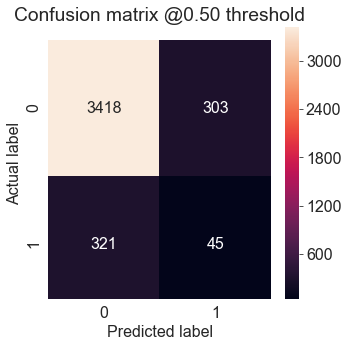

In [389]:
plot_cm(y_val, loaded_model.predict(dvalidation), p=0.5)

## Summary

The model identifies only 12% of the readmitted patients (lower right quadrant) but performs well (92%) on non-readmitted patients (upper left quadrant). Misclassifying a 

## Cumulative Gain Curve

In [242]:
y_val_pred = loaded_model.predict(dvalidation)
print(y_val_pred)

[0.50277746 0.32433617 0.36777008 ... 0.35363394 0.37354103 0.32595357]


In [243]:
class_0 = [1 - pred for pred in y_val_pred]
class_1 = [pred for pred in y_val_pred]

In [244]:
validation_predictions = pd.DataFrame()
validation_predictions['class_0'] = class_0
validation_predictions['class_1'] = class_1
validation_predictions

,class_0,class_1
0,0.497223,0.502777
1,0.675664,0.324336
2,0.632230,0.367770
3,0.509611,0.490389
4,0.630957,0.369043
...,...,...
4082,0.596986,0.403014
4083,0.623354,0.376646
4084,0.646366,0.353634
4085,0.626459,0.373541


In [ ]:
# Import the matplotlib.pyplot module 
import matplotlib.pyplot as plt

# Import the scikitplot module
import scikitplot as skplt

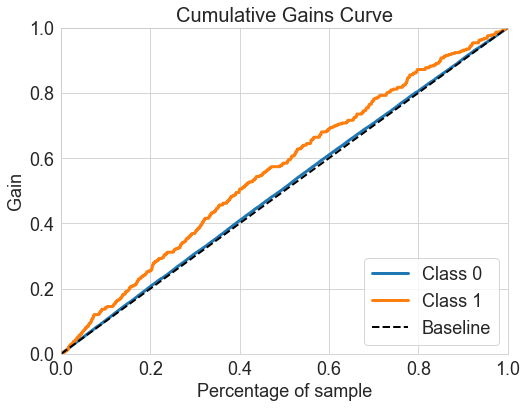

In [253]:

# Plot the cumulative gains graph
skplt.metrics.plot_cumulative_gain(
    list(y_val), validation_predictions, figsize=(8, 6), title_fontsize=20, text_fontsize=18
)
plt.show()

**If the healthcare provider's goal was to reach say 50% of the patients that are most likely to be readmitted then using the cumulative gain curve they can determine that roughly just about 40% of the most likely most likely patients would need to be used to achieve that.**

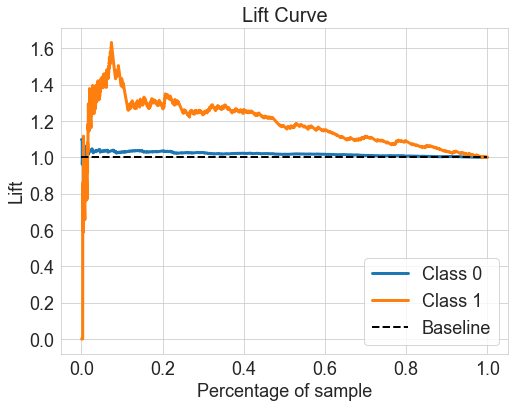

In [254]:
skplt.metrics.plot_lift_curve(
    list(y_val), validation_predictions, figsize=(8, 6), title_fontsize=20, text_fontsize=18
)
plt.show()

**The lift curve here shows the models effectiveness over no model at all. For Class 1 at 50% the model is ~1.2 times better than a random model.**

## Precision and Recall Trade Off¶

False negatives are costly in our example. Missing the readmission of sick patients is terrible. So you don't want to miss any patients who are likely to be readmitted --- we'd rather put up with false alarms about potentially readmitted patients instead of missing readmitted patients entirely. In other words, false negatives cost more than false positives. We may want to be less stringent about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a lower threshold.

So to keep the percentage of false negatives lower, we must raise the Recall.


By changing the probability threshold, it is possible to influence precision and recall.

**Goal: Increase Recall (Model captures as many true positives as possible)**

### Compute Precision and Recall Scores

In [93]:
precision = precision_score(y_true=y_val, 
                            y_pred=y_val_preds)
print ("Precision on validation data: {:.3f}".format(precision))

Precision on validation data: 0.129


In [94]:
recall = recall_score(y_true=y_val, 
                      y_pred=y_val_preds)
print ("Recall on validation data: {:.3f}".format(recall))

Recall on validation data: 0.123


### Precision-Recall Curve

In [95]:
def apply_threshold(probabilities, threshold): 
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else 0)
    return prediction

In [96]:
threshold_values = np.linspace(0, 0.5, num=100)
print (threshold_values)

[0.         0.00505051 0.01010101 0.01515152 0.02020202 0.02525253
 0.03030303 0.03535354 0.04040404 0.04545455 0.05050505 0.05555556
 0.06060606 0.06565657 0.07070707 0.07575758 0.08080808 0.08585859
 0.09090909 0.0959596  0.1010101  0.10606061 0.11111111 0.11616162
 0.12121212 0.12626263 0.13131313 0.13636364 0.14141414 0.14646465
 0.15151515 0.15656566 0.16161616 0.16666667 0.17171717 0.17676768
 0.18181818 0.18686869 0.19191919 0.1969697  0.2020202  0.20707071
 0.21212121 0.21717172 0.22222222 0.22727273 0.23232323 0.23737374
 0.24242424 0.24747475 0.25252525 0.25757576 0.26262626 0.26767677
 0.27272727 0.27777778 0.28282828 0.28787879 0.29292929 0.2979798
 0.3030303  0.30808081 0.31313131 0.31818182 0.32323232 0.32828283
 0.33333333 0.33838384 0.34343434 0.34848485 0.35353535 0.35858586
 0.36363636 0.36868687 0.37373737 0.37878788 0.38383838 0.38888889
 0.39393939 0.3989899  0.4040404  0.40909091 0.41414141 0.41919192
 0.42424242 0.42929293 0.43434343 0.43939394 0.44444444 0.44949

In [97]:
# Compute Precision for every threshold value
precision_all = [precision_score(y_true=y_val, y_pred=apply_threshold(loaded_model.predict(dvalidation), threshold)) 
                 for threshold in threshold_values ]

# Compute Recall for every threshold value
recall_all = [recall_score(y_true=y_val, y_pred=apply_threshold(loaded_model.predict(dvalidation), threshold)) 
              for threshold in threshold_values]

Let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

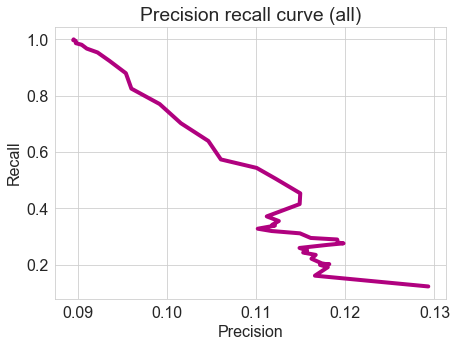

In [255]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis='x', nbins=5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color='#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 20})


plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

In [99]:
new_list = []
for i in zip(threshold_values, recall_all):
    thre, recall = i

    if recall >= 0.85:
        new_list.append(thre)

print(max(new_list))

0.3282828282828283


Legitimate No Readmission Detected  (True Negatives) :  668

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  3053

Legitimate Readmission Missed       (False Negatives):  44

Legitimate Readmission Detected     (True Positives) :  322


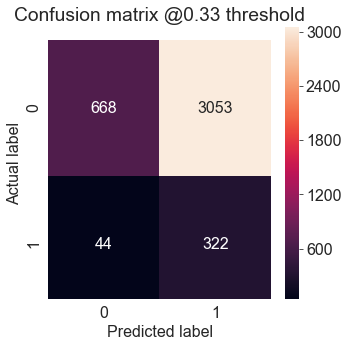

In [102]:
plot_cm(y_val, loaded_model.predict(dvalidation), p=0.3282828282828283)

In [103]:
print('Area under the curve : %f' %
      (metrics.roc_auc_score(y_val, y_val_preds)))

Area under the curve : 0.520761


## Summary
**By lowering the threshold to 0.32, the model can now identify 88% of the readmitted patients but at a cost of misclassifying a patients as potential candidates for readmisssion while they are not.**

## Test Data

In [105]:
y_test_pred_proba = loaded_model.predict(dtest)
# Threshold
thresh=0.3282828282828283
y_test_preds = [1 if pred >thresh else 0 for pred in y_test_pred_proba]

Legitimate No Readmission Detected  (True Negatives) :  2299

Legitimate No Readmission 
Incorrectly Detected as Readmission (False Positives):  10514

Legitimate Readmission Missed       (False Negatives):  148

Legitimate Readmission Detected     (True Positives) :  1126


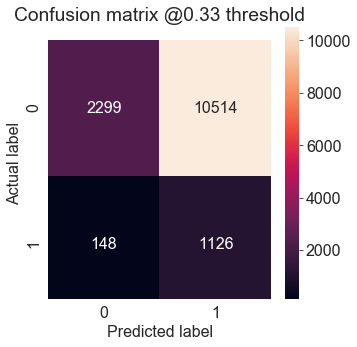

In [106]:
plot_cm(y_test, loaded_model.predict(dtest), p=0.3282828282828283)

In [107]:
print('Area under the curve : %f' %
      (metrics.roc_auc_score(y_test, y_test_preds)))

Area under the curve : 0.531629


## Feature Importance

Text(0.5, 0, 'Score')

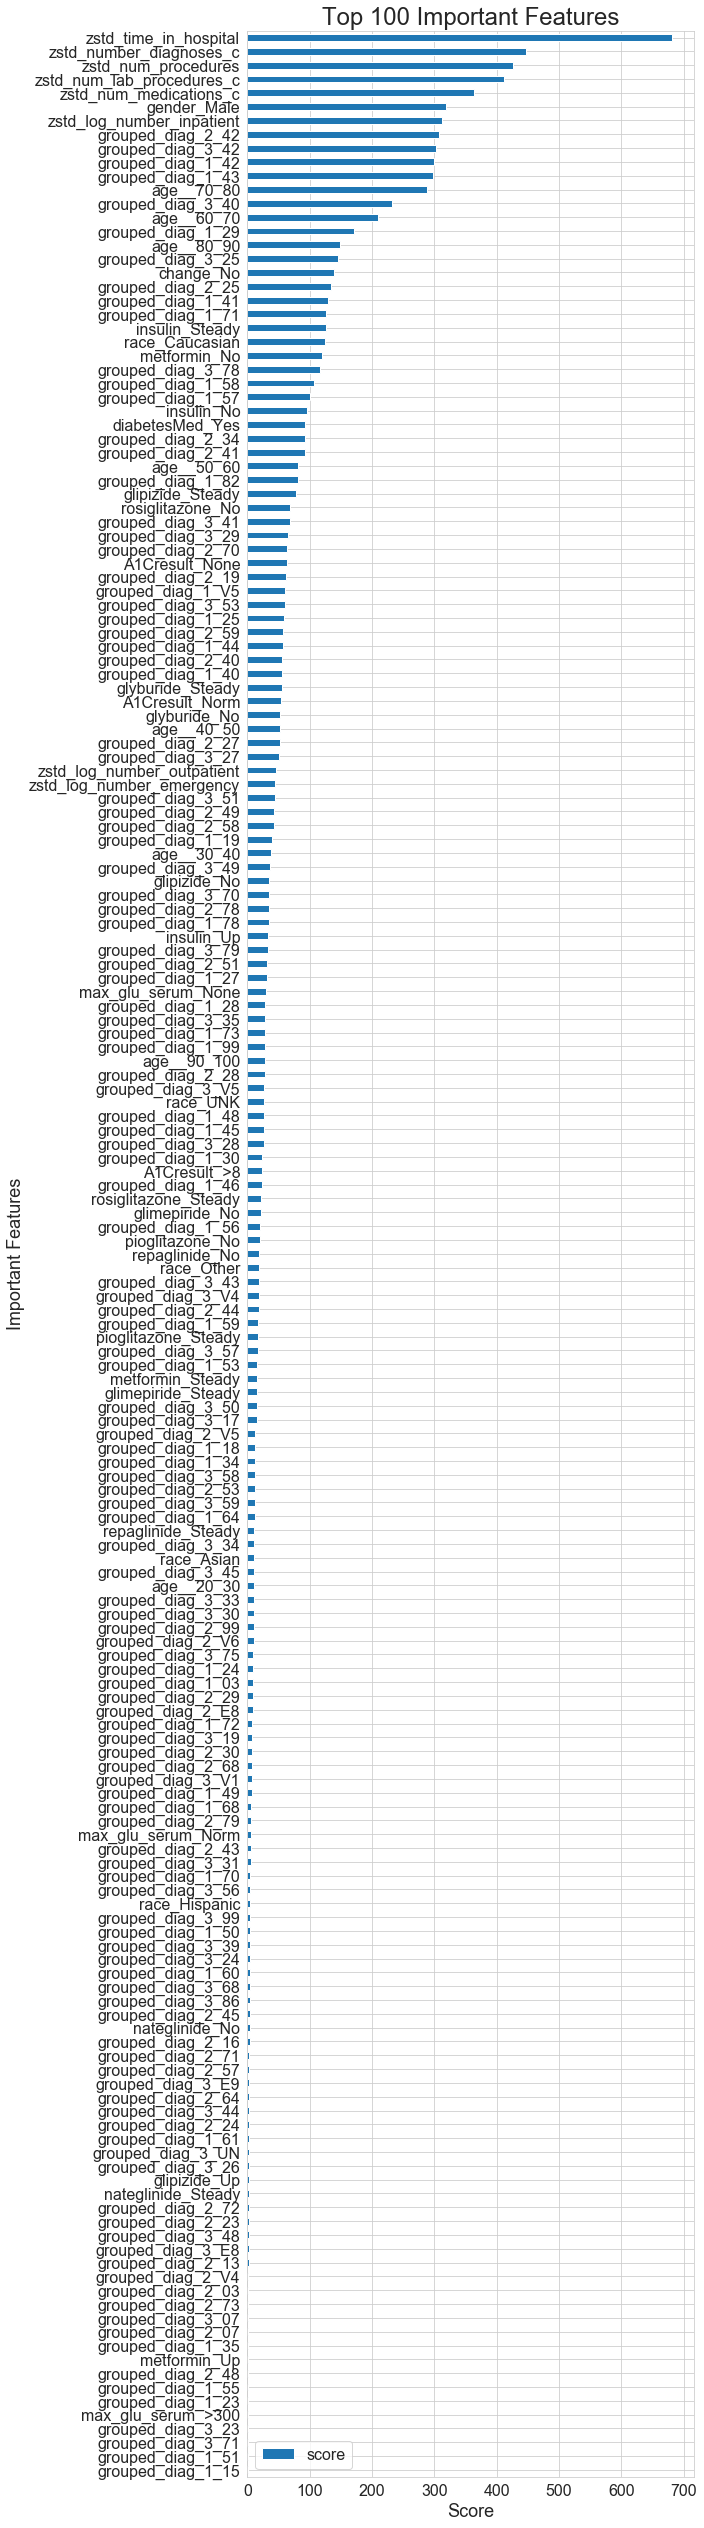

In [171]:
feature_important = loaded_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
fig, ax = plt.subplots(figsize=(8,45))
feature_importance_df.plot(kind='barh', ax=ax)
ax.set_title("Top 100 Important Features", fontsize=24)
ax.set_ylabel("Important Features", fontsize=18)
ax.set_xlabel("Score", fontsize=18)

In [210]:
results = pd.DataFrame()
results["columns"] = keys
results['score'] = values 

In [212]:
top_25_ranked = results.sort_values(by='score', ascending=False)[:25]
bottom_25_ranked = results.sort_values(by='score', ascending=False)[-25:]

In [213]:
top_25_ranked

,columns,score
0,zstd_time_in_hospital,682
17,zstd_number_diagnoses_c,447
28,zstd_num_procedures,426
20,zstd_num_lab_procedures_c,411
15,zstd_num_medications_c,363
44,gender_Male,319
8,zstd_log_number_inpatient,312
35,grouped_diag_2_42,308
4,grouped_diag_3_42,302
66,grouped_diag_1_42,300


In [214]:
bottom_25_ranked

,columns,score
150,grouped_diag_2_13,2
158,grouped_diag_1_61,2
169,nateglinide_Steady,2
165,grouped_diag_3_26,2
164,grouped_diag_2_72,2
141,glipizide_Up,2
114,grouped_diag_3_UN,2
156,grouped_diag_3_48,2
173,grouped_diag_3_E8,2
145,grouped_diag_2_23,2


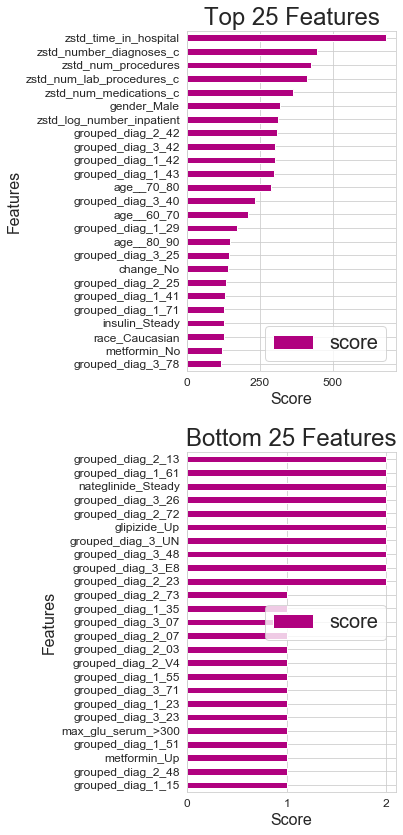

In [256]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,12))

top_25_ranked[::-1].plot(kind='barh', x="columns", y='score', ax = ax1, fontsize=12, color='#B0017F')
ax1.set_title("Top 25 Features")
ax1.set_ylabel('Features', fontsize=16)
ax1.set_xlabel('Score', fontsize=16)


bottom_25_ranked[::-1].plot(kind='barh', x="columns", y='score', ax = ax2, fontsize=12, color='#B0017F')
ax2.set_title("Bottom 25 Features")
ax2.set_ylabel('Features', fontsize=16)
ax2.set_xlabel('Score', fontsize=16)

plt.tight_layout()

## Patients with heart diseases are the most likely to be readmitted

![](figures/400_diseases.png)
![](figures/420_diseases.png)

## Are the top 2 features "time_in_hospital", "num_diagnoses" significantly different in the two groups of patients?

### Time In Hospital

In [112]:
# Separate the two groups
time_hospital_no_readmission = df.loc[df["readmitted"]==0, "time_in_hospital"]
time_hospital_readmission = df.loc[df["readmitted"]==1, "time_in_hospital"]
n_time_hospital_no_readmission = len(time_hospital_no_readmission)
n_time_hospital_readmission = len(time_hospital_readmission)

# Compute the mean time_in_hospital for each group
mu_no_readmission = round(np.mean(time_hospital_no_readmission), 3)
mu_readmission = round(np.mean(time_hospital_readmission), 3)

# Compute the standard deviation time_in_hospital for each group
std_no_readmission = round(np.std(time_hospital_no_readmission), 3)
std_readmission = round(np.std(time_hospital_readmission), 3)

print(f"For the patient group (n={n_time_hospital_no_readmission}) not readmitted Mean Time in Hospital = {mu_no_readmission} +/-{std_no_readmission} days")
print(f"For the patient group (n={n_time_hospital_readmission}) readmitted Mean Time in Hospital = {mu_readmission} +/-{std_readmission} days ")

For the patient group (n=64141) not readmitted Mean Time in Hospital = 4.233 +/-2.923 days
For the patient group (n=6293) readmitted Mean Time in Hospital = 4.797 +/-3.058 days 


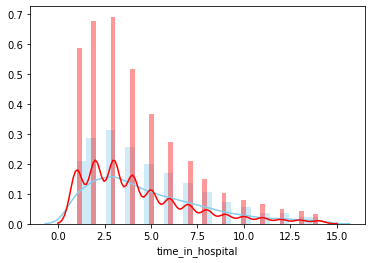

In [100]:
sns.distplot(time_hospital_readmission, color="skyblue", label="Readmission")
sns.distplot(time_hospital_no_readmission, color="red", label="No Readmission")

* **Null Hypothesis**: Time in hospital is not important 

* **Alternate Hypothesis**: Time in hospital is important

In [107]:
from scipy.stats import ttest_ind_from_stats
# seed the random number generator

stat, p = ttest_ind_from_stats(mean1=mu_no_readmission, std1=std_no_readmission, nobs1=n_time_hospital_no_readmission, \
                               mean2=mu_readmission, std2=std_readmission, nobs2=n_time_hospital_readmission, \
                               equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-14.016, p=0.000
Different distributions (reject H0)


### Number of diagnoses

In [133]:
# Separate the two groups
number_diagnoses_no_readmission = df.loc[df["readmitted"]==0, "number_diagnoses"]
number_diagnoses_readmission = df.loc[df["readmitted"]==1, "number_diagnoses"]
n_number_diagnoses_no_readmission = len(number_diagnoses_no_readmission)
n_number_diagnoses_readmission = len(number_diagnoses_readmission)

# Compute the mean time_in_hospital for each group
mu_diagnoses_no_readmission = round(np.mean(number_diagnoses_no_readmission), 3)
mu_diagnoses_readmission = round(np.mean(number_diagnoses_readmission), 3)

# Compute the standard deviation time_in_hospital for each group
std_diagnoses_no_readmission = round(np.std(number_diagnoses_no_readmission), 3)
std_diagnoses_readmission = round(np.std(number_diagnoses_no_readmission), 3)

print(f"For the patient group (n={n_number_diagnoses_no_readmission}) not readmitted Mean number diagnoses = {mu_diagnoses_no_readmission} +/-{std_diagnoses_no_readmission}")
print(f"For the patient group (n={n_number_diagnoses_readmission}) readmitted Mean number diagnoses = {mu_diagnoses_readmission} +/-{std_diagnoses_readmission}")


For the patient group (n=64141) not readmitted Mean number diagnoses = 7.203 +/-2.012
For the patient group (n=6293) readmitted Mean number diagnoses = 7.514 +/-2.012


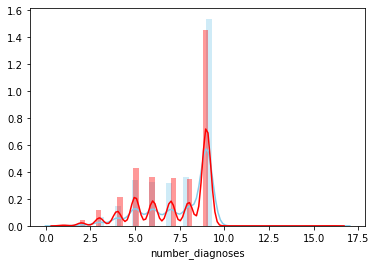

In [134]:
sns.distplot(number_diagnoses_readmission, color="skyblue", label="Readmission")
sns.distplot(number_diagnoses_no_readmission, color="red", label="No Readmission")

In [135]:
from scipy.stats import ttest_ind_from_stats
# seed the random number generator

stat, p = ttest_ind_from_stats(mean1=mu_diagnoses_no_readmission, std1=std_diagnoses_no_readmission, nobs1=n_number_diagnoses_no_readmission, \
                               mean2=mu_diagnoses_readmission, std2=std_diagnoses_readmission, nobs2=n_number_diagnoses_readmission, \
                               equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-11.701, p=0.000
Different distributions (reject H0)


# Summary
* The model built here should be used only to predict readmission of patients of the Caucasian race in the age group of 50-90 years old. Deploying this model on any other race or age group can result is significant errors.


* The model identified the following features as most important in predicting readmission: 
    
    *	Time a patient spent in the hospital
    
    *	Number of diagnosis
    
    *	Number of procedures a patient underwent
    
    *	Number of lab procedures a patient underwent
    
    *	The number of medications the patient is prescribed
A high value of these features indicate that the patient is probably very sick and needs continuous attention. 


* The model also identifies patients with diseases associated with the circulatory and the respiratory systems as a high-risk group. This is consistent with published research that people suffering heart diseases and infections such as pneumonia are more likely to be readmitted than others in the hospital.


* Age is another important factor in determining if a patient is readmitted or not. Older people between 60-90 years are more likely to be readmitted. It is also important to keep in mind that the majority of the patients in the dataset are in this age.


* The model performs about 1.2 times better than a random guess in identifying readmitted patients. To identify at least 50% of the readmitted patients, according to the model the healthcare provides should target 40% of the most likely patients.


## Permutation Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [35]:
xgb_model = XGBClassifier(max_depth=11,
                          min_child_weight=5,
                          eta=0.01,
                          subsample=1,
                          colsample_bytree= 0.8,
                          objective='binary:logistic',
                          eval_metric= 'auc')

xgb_model.fit(data_X_smote.values, data_y_smote, early_stopping_rounds=10, 
             eval_set=[(X_val.values, y_val)], verbose=False)


# Predition
pred_test = xgb_model.predict(X_val.values)

/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rajesharasada/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

In [363]:
pred_test

array([1, 0, 0, ..., 0, 0, 0])

In [36]:
perm = PermutationImportance(xgb_model, random_state=1)
perm.fit(data_X_smote.values, data_y_smote)
names = data_X_smote.columns.tolist()
eli5.show_weights(perm, feature_names = names)

Weight,Feature
0.2318 ± 0.0033,zstd_time_in_hospital
0.0160 ± 0.0006,grouped_diag_2_42
0.0149 ± 0.0005,age__70_80
0.0095 ± 0.0004,race_Caucasian
0.0082 ± 0.0006,grouped_diag_1_42
0.0076 ± 0.0003,age__80_90
0.0071 ± 0.0003,grouped_diag_2_25
0.0067 ± 0.0001,grouped_diag_1_43
0.0065 ± 0.0002,gender_Male
0.0058 ± 0.0005,grouped_diag_3_42


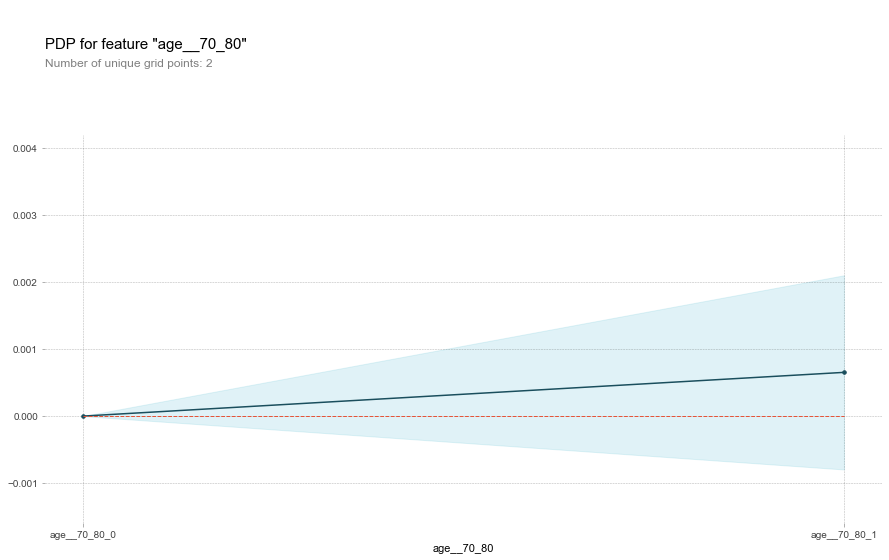

In [138]:
from pdpbox import pdp, get_dataset, info_plots

feat_name = 'age__70_80'
names = X_val.columns.tolist()
pdp_dist = pdp.pdp_isolate(model=xgb_model, dataset=X_val, model_features=names, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

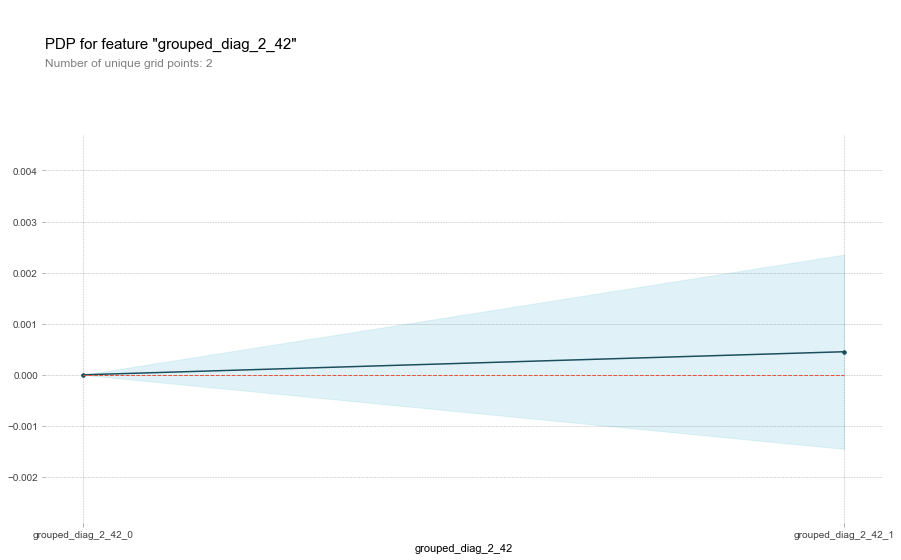

In [139]:
from pdpbox import pdp, get_dataset, info_plots

feat_name = 'grouped_diag_2_42'
names = X_val.columns.tolist()
pdp_dist = pdp.pdp_isolate(model=xgb_model, dataset=X_val, model_features=names, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

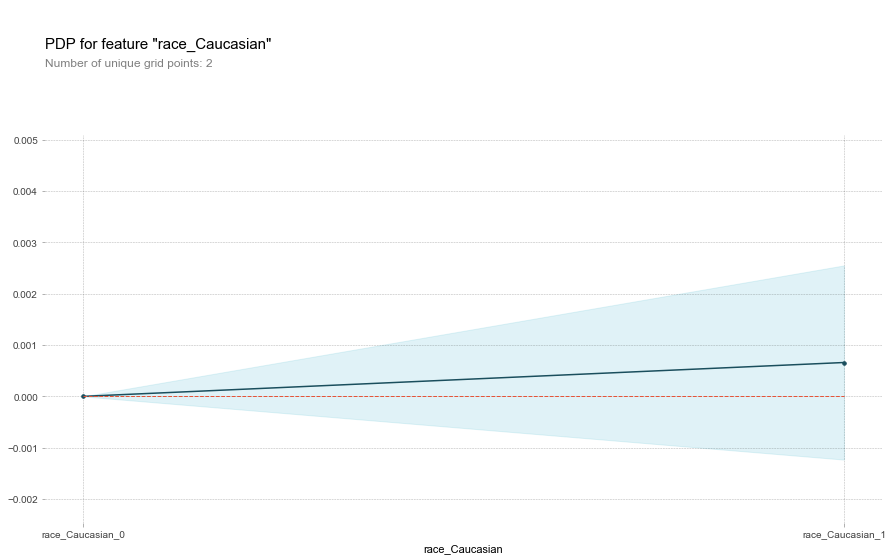

In [140]:
feat_name="race_Caucasian"
names = X_val.columns.tolist()
pdp_dist = pdp.pdp_isolate(model=xgb_model, dataset=X_val, model_features=names, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

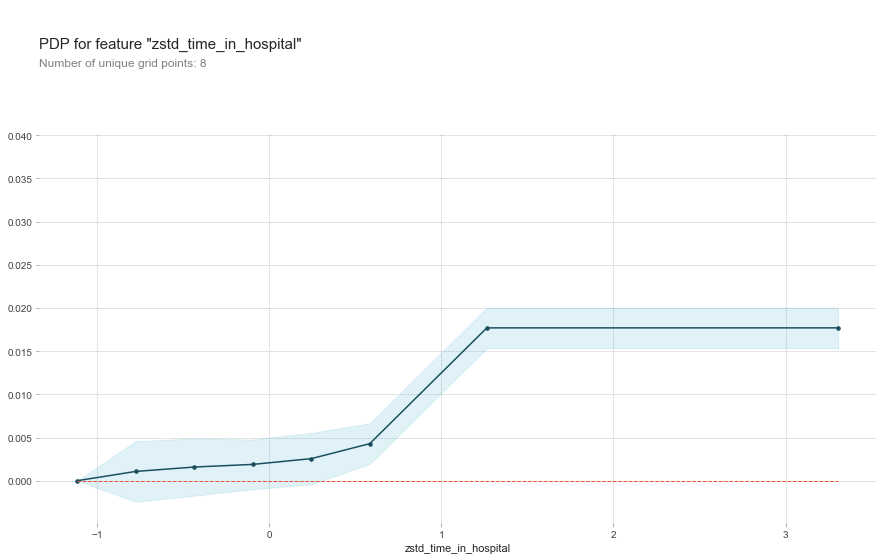

In [401]:
feat_name = 'zstd_time_in_hospital'
names = X_val.columns.tolist()
pdp_dist = pdp.pdp_isolate(model=xgb_model, dataset=X_val, model_features=names, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [404]:
# Separate the two groups
time_hospital_no_readmission = validation_df.loc[validation_df["readmitted"]==0, "zstd_time_in_hospital"]
time_hospital_readmission = validation_df.loc[validation_df["readmitted"]==1, "zstd_time_in_hospital"]
n_time_hospital_no_readmission = len(time_hospital_no_readmission)
n_time_hospital_readmission = len(time_hospital_readmission)

# Compute the mean time_in_hospital for each group
mu_no_readmission = round(np.mean(time_hospital_no_readmission), 3)
mu_readmission = round(np.mean(time_hospital_readmission), 3)

# Compute the standard deviation time_in_hospital for each group
std_no_readmission = round(np.std(time_hospital_no_readmission), 3)
std_readmission = round(np.std(time_hospital_readmission), 3)

print(f"For the patient group (n={n_time_hospital_no_readmission}) not readmitted Mean Time in Hospital = {mu_no_readmission} +/-{std_no_readmission} days")
print(f"For the patient group (n={n_time_hospital_readmission}) readmitted Mean Time in Hospital = {mu_readmission} +/-{std_readmission} days ")

For the patient group (n=3721) not readmitted Mean Time in Hospital = -0.004 +/-0.986 days
For the patient group (n=366) readmitted Mean Time in Hospital = 0.136 +/-1.054 days 


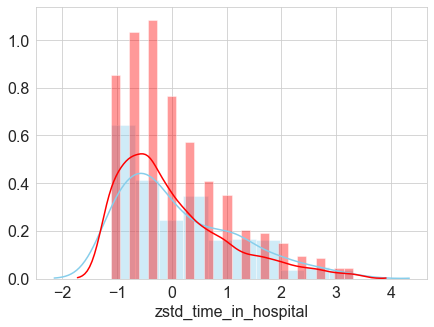

In [405]:
sns.distplot(time_hospital_readmission, color="skyblue", label="Readmission")
sns.distplot(time_hospital_no_readmission, color="red", label="No Readmission")

In [406]:
from scipy.stats import ttest_ind_from_stats
# seed the random number generator

stat, p = ttest_ind_from_stats(mean1=mu_no_readmission, std1=std_no_readmission, nobs1=n_time_hospital_no_readmission, \
                               mean2=mu_readmission, std2=std_readmission, nobs2=n_time_hospital_readmission, \
                               equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-2.438, p=0.015
Different distributions (reject H0)
